<a href="https://colab.research.google.com/github/mgfreeman23/ASL-Classification-Model/blob/main/ASL_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASL Alphabet
Computer Vision Multiclass Classification

In [1]:
# Connect to google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Libraries

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
# Use GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Directory for training data

data_dir = 'gdrive/My Drive/CAIS++/asl_alphabet/train/'

In [5]:
from torch.utils.data import DataLoader, Subset, random_split

# Image transformations so it can be used with ResNet

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                               )

# Loading data and splitting it into training and validation

dataset = datasets.ImageFolder(data_dir, transform=transform)

dataset_size = len(dataset)
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


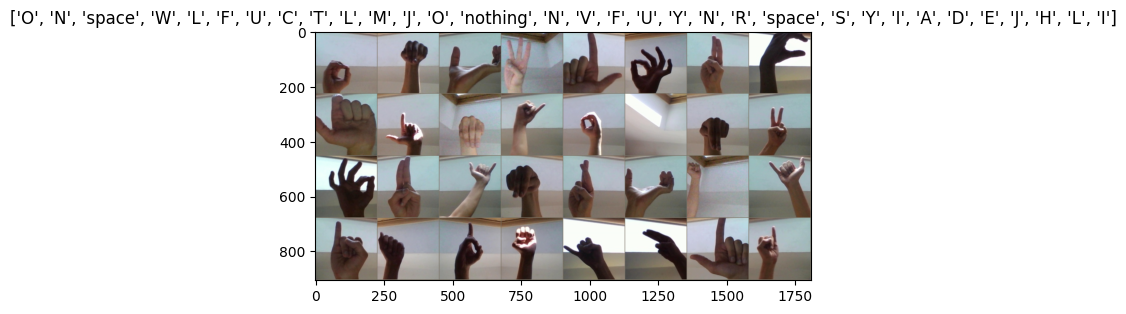

In [6]:
class_names = dataset.classes

# Show some images and their classifications

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
# Set up the ResNet model to work for this classification task -> using ResNet with 34 layers

model_ft = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

# find the input size of the FC layers
num_ftrs = model_ft.fc.in_features

# adjust to work for 29 different categories
model_ft.fc = torch.nn.Linear(num_ftrs, 29)

# save model to device
model_ft = model_ft.to(device)

# define loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# define optimizer
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001 )

# decay your learning rate across epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 100MB/s]


In [9]:
# Function for model training

def train_model(model, criterion, optimizer, scheduler,  num_epochs=16):
    model.to(device)
    since = time.time()
    # initialize weights and accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # go through all the epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Model in training mode for training set
        model.train()

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # get predictions
            outputs = model(inputs)
            # determine loss
            loss = criterion(outputs, labels)
            # backward + optimize
            loss.backward()
            optimizer.step()

        # Model in evaluation mode for validation set
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_samples = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_dataloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels)

                _, predicted = torch.max(val_outputs, 1)
                correct_preds += (predicted == val_labels).sum().item()
                total_samples += val_labels.size(0)
        # getting performance metric on validation set
        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct_preds / total_samples
        scheduler.step()
       # update if better accuracy
        if accuracy > best_acc:
            best_acc = accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f'Loss: {avg_val_loss:.4f} Acc: {accuracy:.4f}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
# Actual training of the model -> experiment with LESS epochs to avoid overfitting

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler)

Epoch 0/15
----------
Loss: 0.3059 Acc: 0.9051

Epoch 1/15
----------
Loss: 0.1337 Acc: 0.9669

Epoch 2/15
----------
Loss: 0.0555 Acc: 0.9825

Epoch 3/15
----------
Loss: 0.0169 Acc: 0.9955

Epoch 4/15
----------
Loss: 0.1246 Acc: 0.9630

Epoch 5/15
----------
Loss: 0.0167 Acc: 0.9974

Epoch 6/15
----------
Loss: 0.0098 Acc: 0.9974

Epoch 7/15
----------
Loss: 0.0016 Acc: 1.0000

Epoch 8/15
----------
Loss: 0.0008 Acc: 1.0000

Epoch 9/15
----------
Loss: 0.0006 Acc: 1.0000

Epoch 10/15
----------
Loss: 0.0005 Acc: 1.0000

Epoch 11/15
----------
Loss: 0.0006 Acc: 1.0000

Epoch 12/15
----------
Loss: 0.0005 Acc: 1.0000

Epoch 13/15
----------
Loss: 0.0004 Acc: 1.0000

Epoch 14/15
----------
Loss: 0.0003 Acc: 1.0000

Epoch 15/15
----------
Loss: 0.0003 Acc: 1.0000

Training complete in 39m 45s
Best val Acc: 1.0000


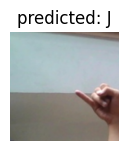

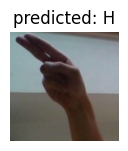

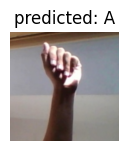

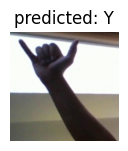

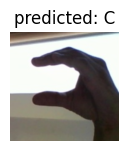

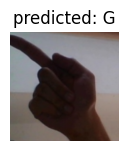

In [11]:
# Example of how the model classifies some images from the data

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft)

In [53]:
# Get testing data

test_data_dir = 'gdrive/My Drive/CAIS++/asl_alphabet/test/'
test_dataset = datasets.ImageFolder(test_data_dir, transform=transform)

# Create DataLoader instances for testing data
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

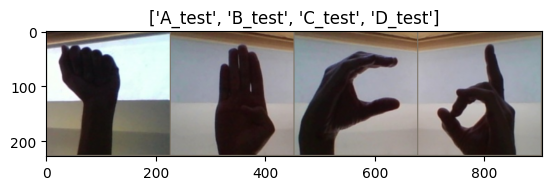

In [54]:
# Demonstrate what the testing data looks like

class_names = test_dataset.classes

# Show some images and their classifications

# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [55]:
# For determining model accuracy

from sklearn.metrics import f1_score

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 100 %


In [57]:
# For determining model F1 score

from sklearn.metrics import f1_score

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

all_true_labels = []
all_predicted_labels = []

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)

        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.item() == prediction.item():
                correct_pred[class_names[label.item()]] += 1
            total_pred[class_names[label.item()]] += 1

            # Collect true and predicted labels for F1 score calculation
            all_true_labels.append(class_names[label.item()])
            all_predicted_labels.append(class_names[prediction.item()])

# Calculate overall F1 score
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

print(f'Overall F1 Score: {f1:.4f}')

Overall F1 Score: 1.0000
